In [ ]:
# Install all required packages
!python3 -m pip -q install sklearn seaborn tueplots mpmath quadpy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpmath import mp, mpf
from scipy.special import polygamma, rel_entr

from tueplots import axes, bundles, figsizes, fonts

from prior_work import compute_delta, compute_epsilon
from utils import (adp2r,
                   bisection,
                   KLDir,
                   r2epsilon,
                   r2adp,
                   r2epsilon_evidence)

# matplotlib parameters
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"figure.dpi": 600})
plt.rcParams.update(fonts.jmlr2001_tex(family="serif"))
plt.rcParams.update(bundles.icml2022(family="serif"))
plt.rcParams.update(figsizes.icml2022_full(nrows=2))
plt.rcParams.update(axes.lines())
plt.rcParams.update(axes.grid(grid_alpha=0.7))

mp.dps = 80

alphaVal = 0.8
linethick = 1.6

Comparing privacy guatantees...
lambda = 2 Done.
lambda = 20 Done.
lambda = 200 Done.


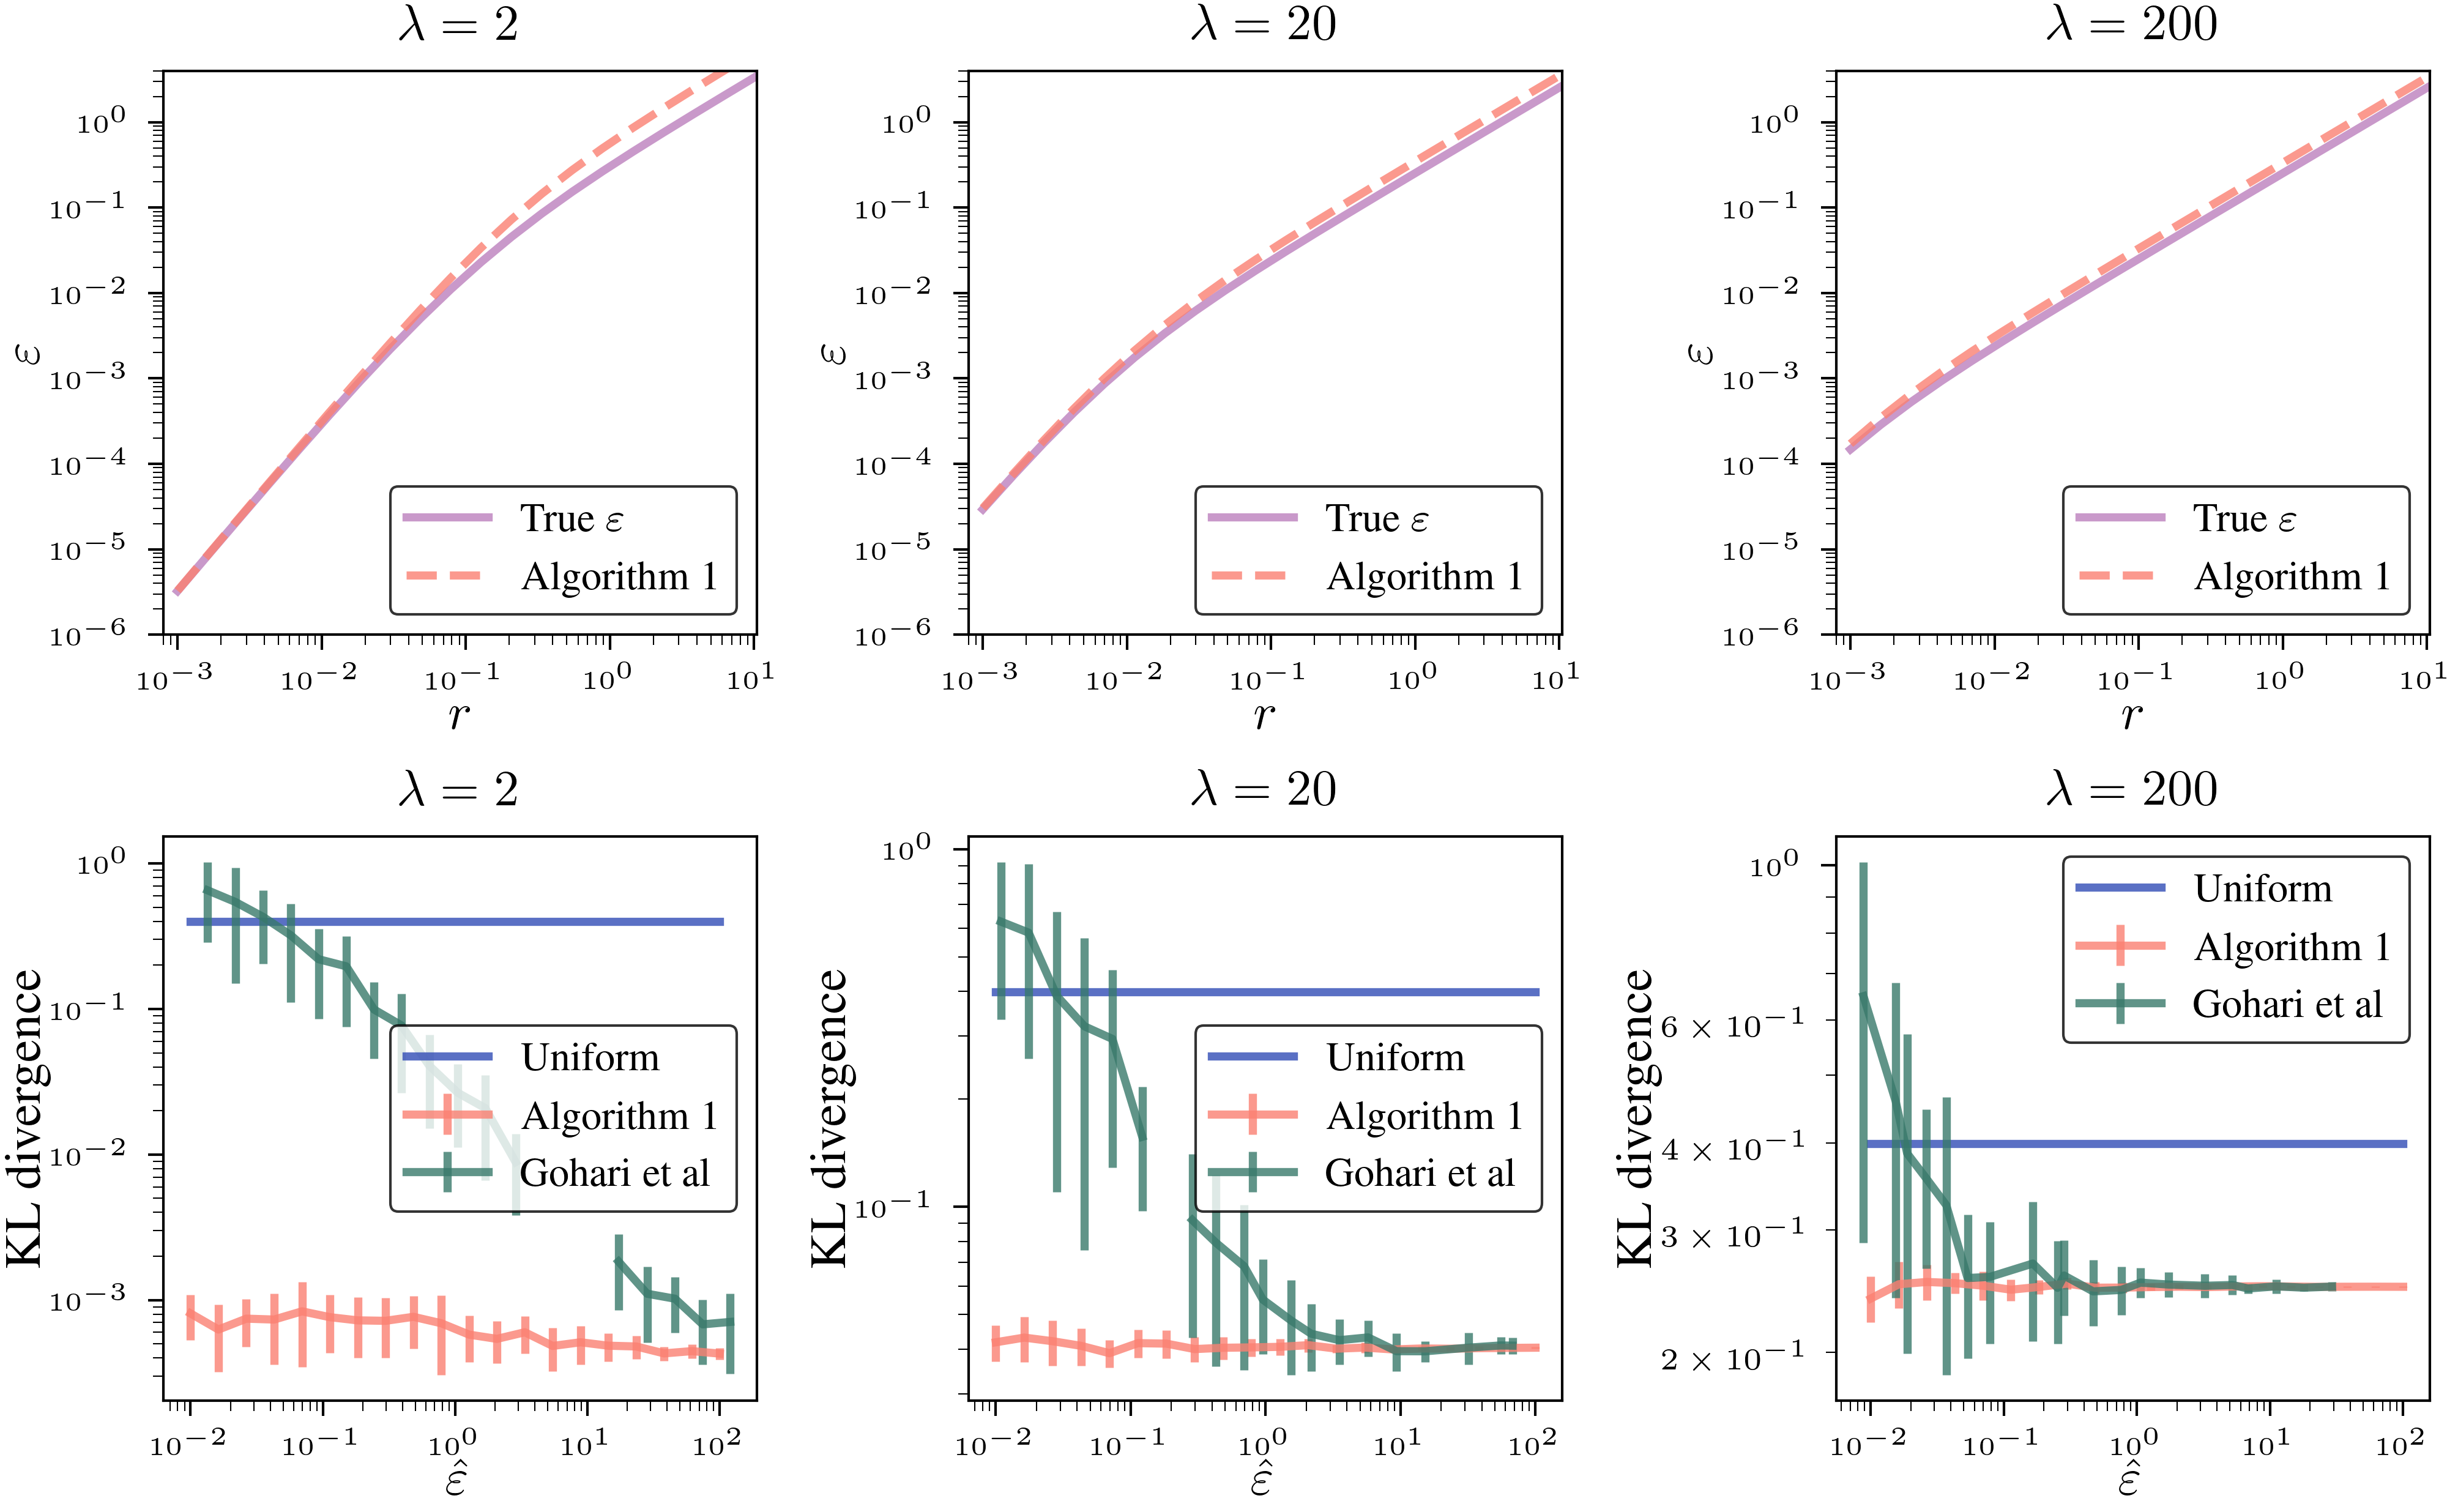

In [110]:
# Plot of RDP guarantees #
%matplotlib inline

d = 6  # number of histograms
W = 2  # hamming distance between two histograms
n_points = 20  # number of points in each plot
n_iter = 20  # number of iterations

rs = np.logspace(-3, 1, n_points)
epsilons = np.logspace(-2, 2, n_points)
x0 = np.array([119,  74, 618, 272,  13, 187])
x1 = np.array([11, 8, 65, 25, 38, 0])
x2 = np.array([11, 7, 65, 25, 38, 1])

N = x0.sum()
Delta_2sq = 2
Delta_inf = 1
lambdas = [2, 20, 200]
delta = 1e-5
prior = 1

fig, axs = plt.subplots(nrows=2, ncols=3)

for lambda_, ax in zip(lambdas, axs[0]):

    true_epsilon = np.zeros(n_points)

    for i, r in enumerate(rs):
        alpha = prior + 4*(lambda_-1)*r*Delta_inf
        true_epsilon[i] = r2epsilon_evidence(x1, x2, r, alpha, lambda_)

    upper_epsilon = r2epsilon(rs, prior, lambda_, Delta_2sq, Delta_inf)

    ax.plot(rs,
            true_epsilon,
            color='#bc80bd',
            lw=linethick,
            label='True $\\varepsilon$',
            alpha=alphaVal)
    ax.plot(rs,
            upper_epsilon,
            '--',
            color='#fb8072',
            linewidth=linethick,
            label='Algorithm 1',
            alpha=alphaVal)

    legend = ax.legend(loc='lower right', fontsize=8)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(0.0008, 10.5)
    ax.set_ylim(1e-6, 4)
    ax.tick_params(axis='both', which='major', labelsize=5)
    ax.set_xlabel('$r$',fontsize=10, labelpad=0)
    ax.set_ylabel('$\\varepsilon$',fontsize=10, labelpad=0)
    ax.set_title('$\\lambda ='+str(lambda_)+'$', fontsize=10)

print("Comparing privacy guatantees...")

for i, (lambda_, ax) in enumerate(zip(lambdas, axs[1])):
    prior_eps = np.zeros(n_points)
    lower_search = 1e-7
    upper_search = 0.2
    for j, r in enumerate(rs):
        alpha = mpf(prior) + 4*(lambda_-1)*r*Delta_inf
        k = N * r + alpha * d
        e1 = (r + alpha) / (N * r + alpha * d)
        e2 = (d - 2) * alpha / (N * r + alpha * d)

        def func(g):
            val = compute_delta(g, k, e1, e2, 'xiao_gimbutas_50')
            diff = val - mpf('1e-5')
            return diff

        new_gamma = bisection(func,
                              lower_search,
                              upper_search,
                              tol=mpf('1e-6'))

        if new_gamma is not None:
            gamma = new_gamma
            prior_eps[j] = compute_epsilon(g=gamma, k=k, W=W, 
                                           e1=e1, e2=e2,
                                           ss=2*r/(N*r + alpha*d))
        else:
            prior_eps[j] = None

    r_from_eps = [adp2r(epsilons[j],
                        prior=1,
                        lambda_=lambda_,
                        delta=1e-5,
                        Delta_2sq=Delta_2sq,
                        Delta_inf=Delta_inf)
                  for j in range(n_points)]
    r_from_eps = np.array(r_from_eps)

    alpha_prior = prior + 4*(lambda_-1)*rs*Delta_inf
    alpha_new = prior + 4*(lambda_-1)*r_from_eps*Delta_inf

    params_prior = (np.multiply.outer(rs, x0) +
                    alpha_prior[:, None])
    params_new = (np.multiply.outer(r_from_eps, x0) +
                  alpha_new[:, None])

    x_stacked = np.tile(x0/N, (n_points, 1))

    kl_prior = np.zeros((n_points, n_iter))
    kl_new = np.zeros((n_points, n_iter))

    rand = np.random.default_rng()
    for idx in range(n_iter):
        out_prior = rand.standard_gamma(params_prior)
        out_prior /= out_prior.sum(-1, keepdims=True)
        out_new = rand.standard_gamma(params_new)
        out_new /= out_new.sum(-1, keepdims=True)

        kl_prior[:, idx] = np.sum(rel_entr(x_stacked, out_prior),
                                  axis=1)
        kl_new[:, idx] = np.sum(rel_entr(x_stacked, out_new),
                                axis=1)

    uniform_kl = np.sum(x0/N*np.log(x0/N)) + np.log(d)

    ax.plot(
        epsilons,
        uniform_kl * np.ones(n_points),
        color='#314CB6',
        lw=linethick,
        label='Uniform',
        alpha=alphaVal
    )

    ax.errorbar(
        epsilons,
        kl_new.mean(axis=1),
        yerr=kl_new.std(axis=1),
        color='#fb8072',
        lw=linethick,
        label='Algorithm 1',
        alpha=alphaVal
    )

    ax.errorbar(
        prior_eps,
        kl_prior.mean(axis=1),
        yerr=kl_prior.std(axis=1),
        color='#38796b',
        lw=linethick,
        label='Gohari et al',
        alpha=alphaVal
    )

    legend = ax.legend(loc='best', fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('$\\hat\\varepsilon$', fontsize=10, labelpad=0)
    ax.set_ylabel('KL divergence', fontsize=10, labelpad=0)
    ax.set_title('$\\lambda ='+str(lambda_)+'$', fontsize=10)

    print(f"lambda = {lambda_} Done.")

fig.tight_layout()
fig.savefig('RDP.pdf', bbox_inches='tight', format='pdf', dpi=1200)

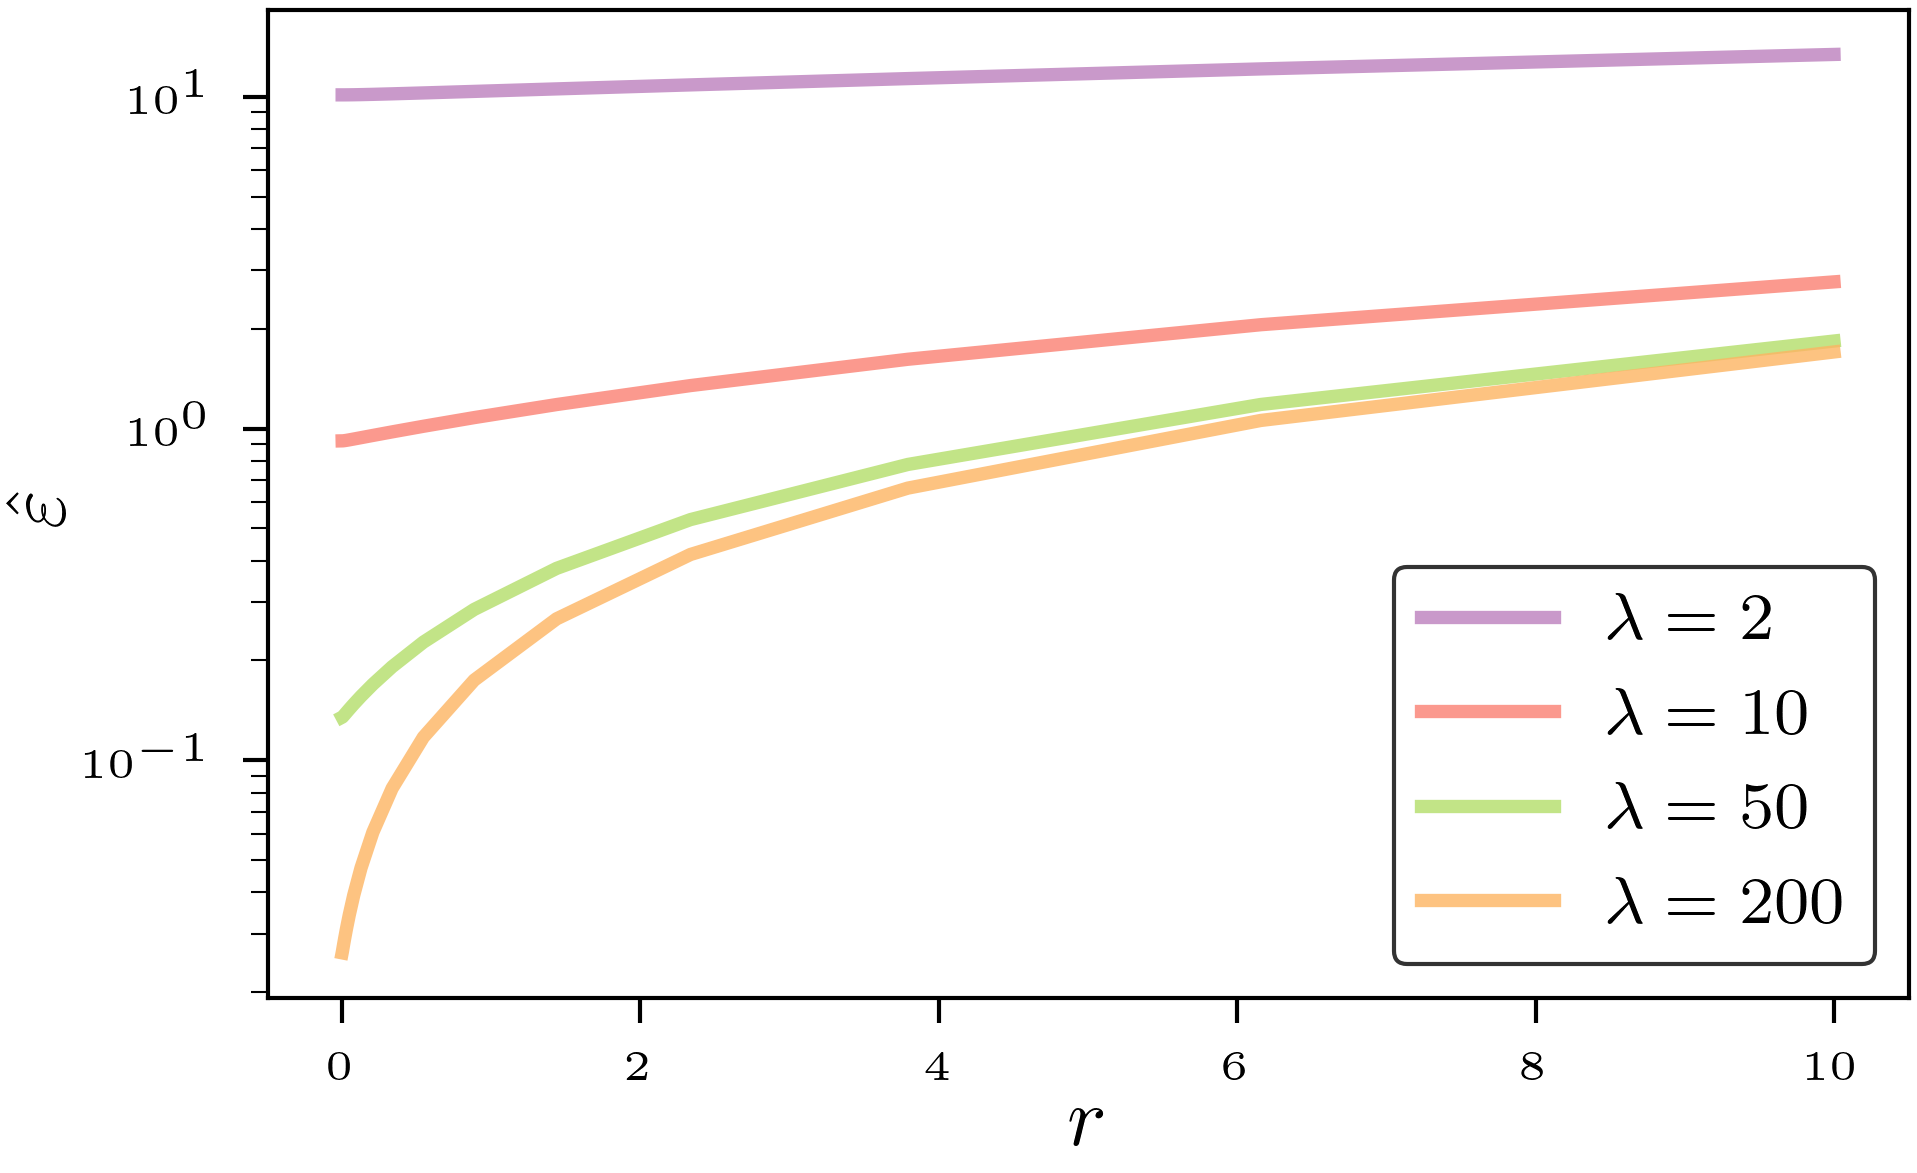

In [19]:
# Plot of Approximate DP guarantees

plt.rcParams.update(figsizes.icml2022_half(nrows=1))

%matplotlib inline

rs = np.logspace(-3, 1, n_points)
Delta_inf = 1
Delta_2sq = 1
delta = 1e-5


def plot_epsilon(lambda_, label, color):

    epsilons = r2adp(rs,
                     prior=1,
                     lambda_=lambda_,
                     delta=delta,
                     Delta_2sq=1,
                     Delta_inf=1)

    plt.plot(rs,
             epsilons,
             linestyle='-',
             lw=linethick,
             label=label,
             color=color,
             alpha=alphaVal)


plot_epsilon(2, '$\\lambda = 2$', '#bc80bd')
plot_epsilon(10, '$\\lambda = 10$', '#fb8072')
plot_epsilon(50, '$\\lambda = 50$', '#b3de69')
plot_epsilon(200, '$\\lambda = 200$', '#fdb462')

legend = plt.legend(loc='lower right', fontsize=8)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=5)
plt.xlabel("$r$", fontsize=10, labelpad=0)
plt.ylabel('$\\hat\\varepsilon$', fontsize=10, labelpad=0)

plt.tight_layout()
plt.savefig('ADP.pdf', format='pdf', dpi=600, bbox_inches='tight', transparent=True)

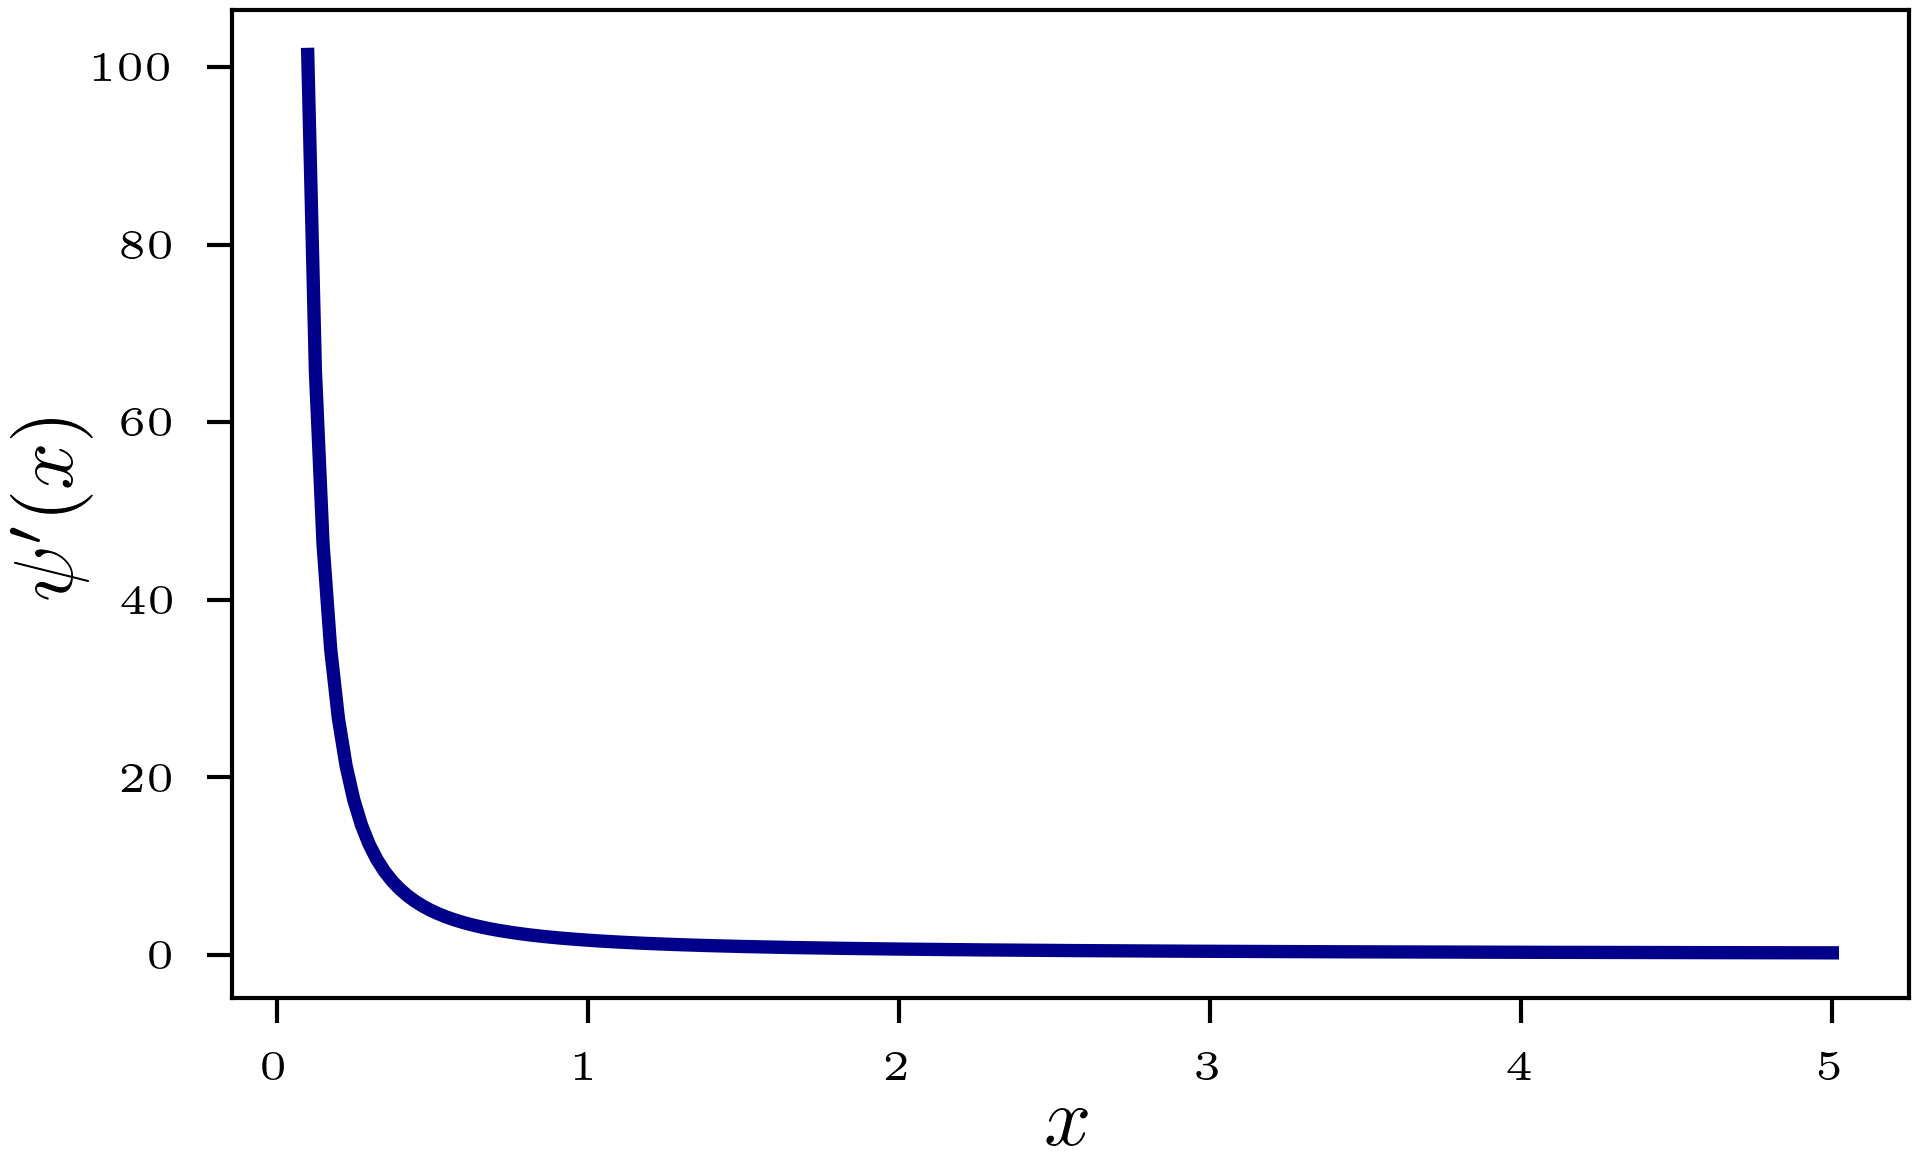

In [20]:
# Plot of the trigamma (psi'(x)) function

plt.rcParams.update(figsizes.icml2022_half(nrows=1))

%matplotlib inline

xs = np.linspace(0.1, 5, 200)
plt.plot(xs,
         polygamma(1, xs),
         linestyle='-',
         lw=linethick,
         color='darkblue'
        )

plt.tick_params(axis='both', which='major', labelsize=5)
plt.xlabel("$x$", fontsize=10, labelpad=0)
plt.ylabel('$\\psi\'(x)$', fontsize=10, labelpad=0)

plt.tight_layout()
plt.savefig('trigamma.pdf', format='pdf', dpi=600, bbox_inches='tight', transparent=True)

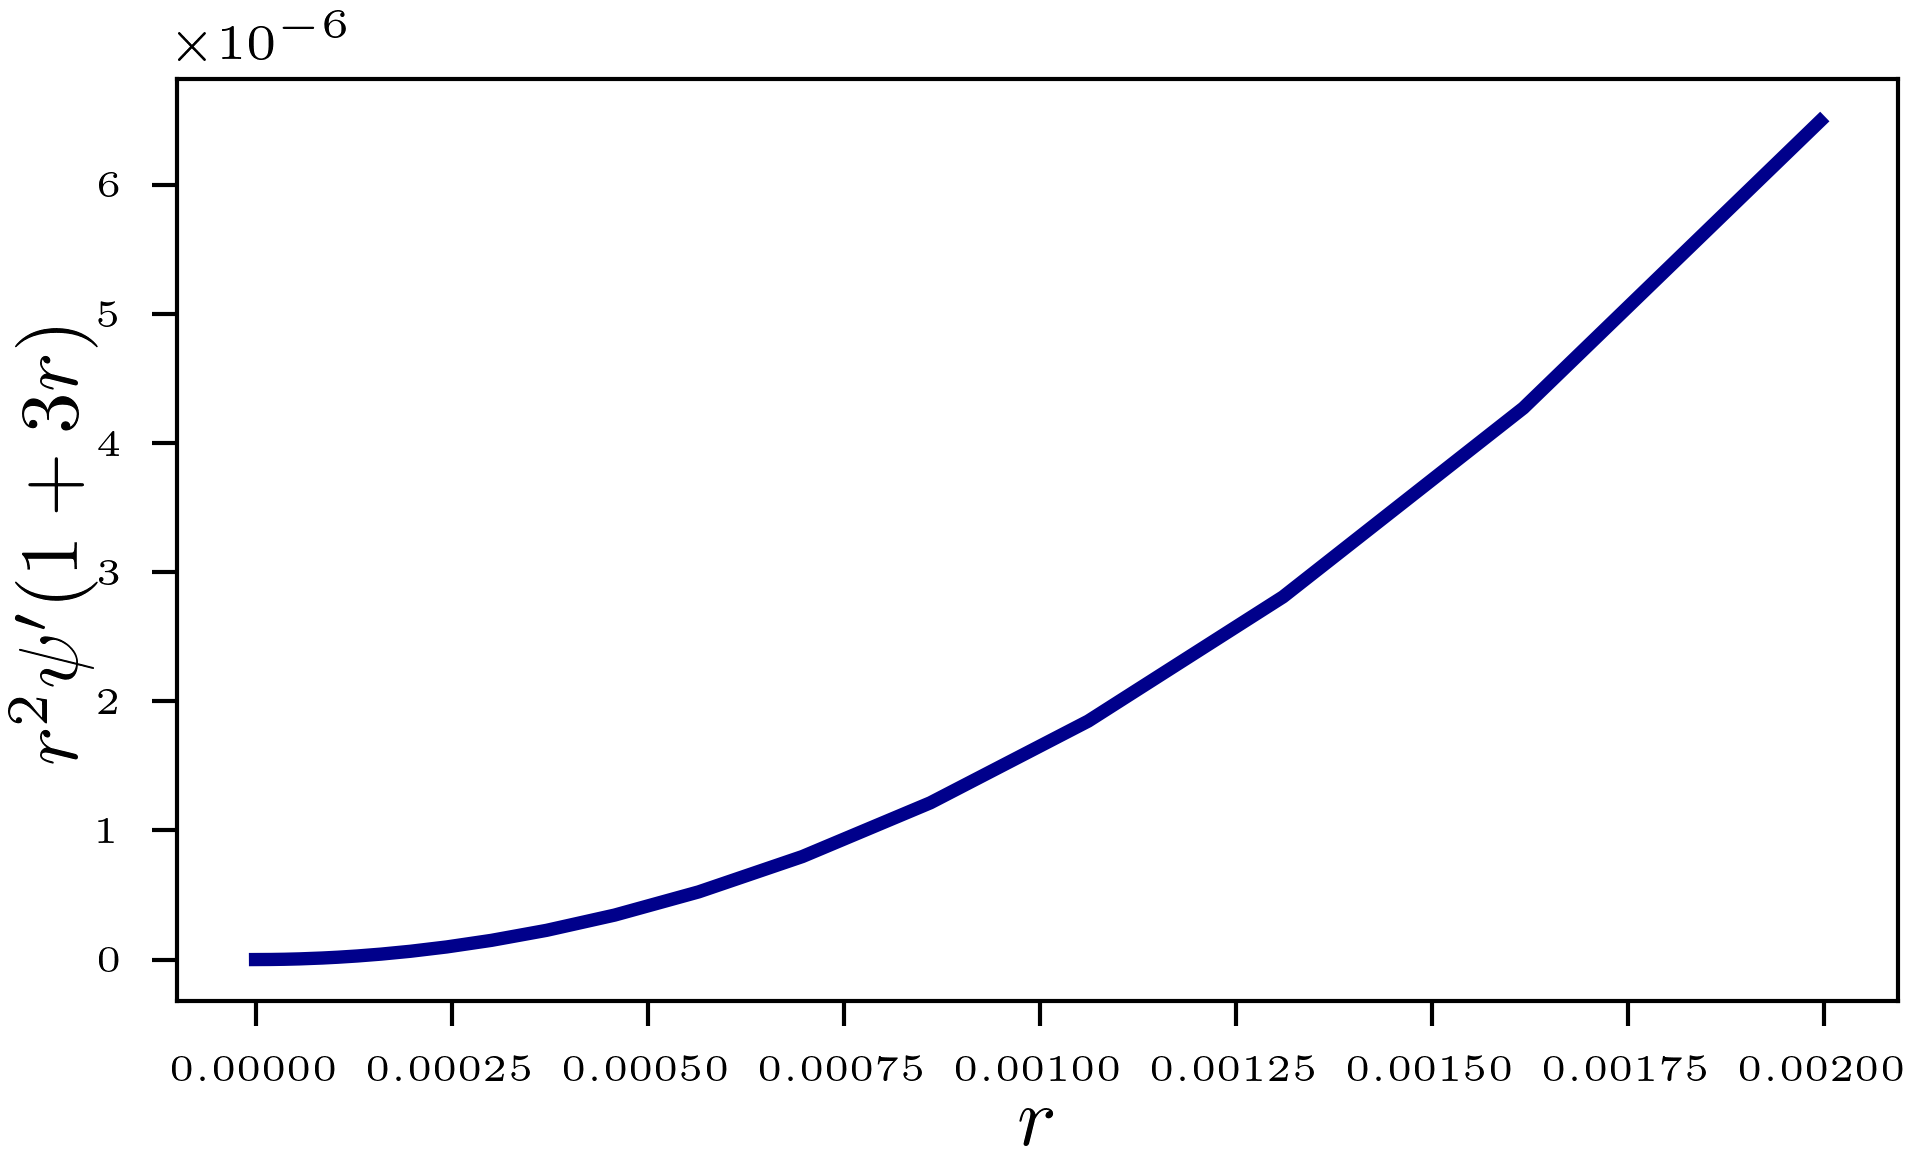

In [21]:
# Plot of Approximate DP guarantees

plt.rcParams.update(figsizes.icml2022_half(nrows=1))

%matplotlib inline

rs = np.logspace(-30, -2.7, 300)
psis = (rs**2) * polygamma(1, 1 + 3 * rs)
plt.plot(rs,
         psis,
         linestyle='-',
         lw=linethick,
         color='darkblue'
        )

plt.tick_params(axis='both', which='major', labelsize=4.5)
plt.xlabel("$r$", fontsize=10, labelpad=0)
plt.ylabel('$r^2\\psi\'(1+3r)$', fontsize=10, labelpad=0)

plt.tight_layout()
plt.savefig('r2psi.pdf', format='pdf', dpi=600, bbox_inches='tight', transparent=True)

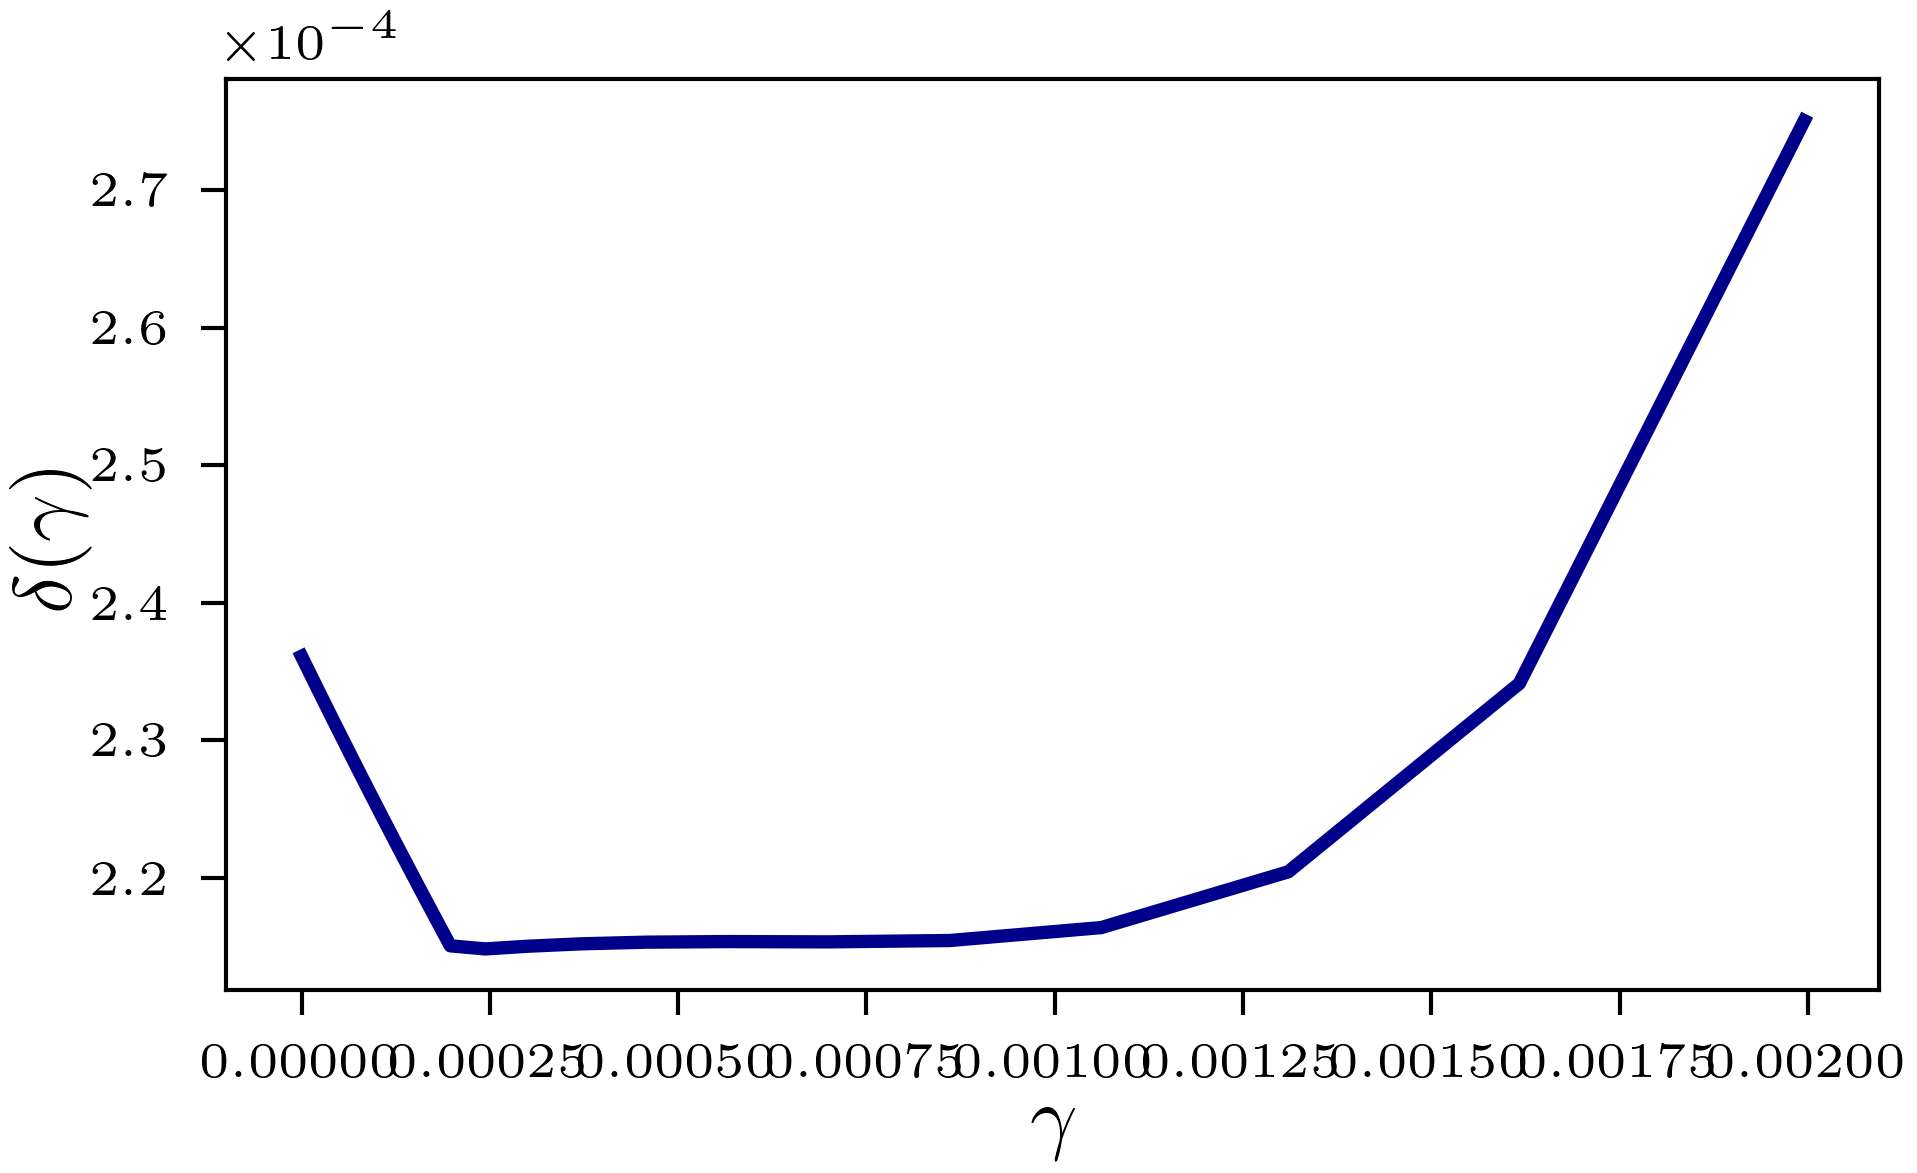

In [6]:
# Plot of delta as a function fo gamma
# in Gohari et al. (2021)

plt.rcParams.update(figsizes.icml2022_half(nrows=1))

%matplotlib inline

r = 0.97
N = 147
d = 6  # number of histograms
Delta_inf = 1
lambda_ = 2
prior = 1
gs = np.logspace(-30, -2.7, 300)

alpha = mpf(prior) + 4*(lambda_-1)*r*Delta_inf
k = N * r + alpha * d
e1 = alpha / (N * r + alpha * d)
e2 = (d - 2) * alpha / (N * r + alpha * d)

vals = [compute_delta(g, k, e1, e2, 'xiao_gimbutas_50')
        for g in gs]

plt.plot(gs,
         vals,
         linestyle='-',
         lw=linethick,
         color='darkblue'
        )

plt.tick_params(axis='y', which='major', labelsize=6)
plt.tick_params(axis='x', which='major', labelsize=4.5)
plt.xlabel("$\\gamma$", fontsize=10, labelpad=0)
plt.ylabel('$\\delta(\\gamma)$', fontsize=10, labelpad=0)
plt.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))

plt.tight_layout()
plt.savefig('delta_plot.pdf', format='pdf', dpi=600, bbox_inches='tight', transparent=True)